# Guide to dask chunking in Spectral-Cube

Dask is a data processing framework integrated into spectral-cube that enables parallel processing of larger-than-memory cubes.

In [1]:
import numpy as np
from astropy.utils.data import download_file
from spectral_cube import SpectralCube

We download a cube from the MAPS survey:

In [2]:
filename = download_file('ftp://ftp.cv.nrao.edu/NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec/HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', cache=True)

We load the cube using the `dask` backend, which allows for some parallelization:

In [3]:
cube = SpectralCube.read(filename, use_dask=True)

In [4]:
cube

DaskSpectralCube with shape=(127, 2048, 2048) and unit=Jy / beam and chunk size (127, 512, 512):
 n_x:   2048  type_x: RA---SIN  unit_x: deg    range:   269.082528 deg:  269.094790 deg
 n_y:   2048  type_y: DEC--SIN  unit_y: deg    range:   -21.961977 deg:  -21.950605 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

# Dask Chunking

In [5]:
# Don't use _data, it will cause problems!  This is _purely_ for visualization purposes
cube._data

dask.array<e23db90f-56a6-4b46-9439, shape=(127, 2048, 2048), dtype=>f4, chunksize=(127, 512, 512), chunktype=numpy.ndarray>

Dask data can be 'chunked' to optimize oeprations along different directions.  

For example, this first 'rechunk' will load full spectra into memory, but will break the cube into sub-cubes:

In [6]:
rechunked_cube_spectrally = cube.rechunk((-1,'auto','auto'))
rechunked_cube_spectrally._data

dask.array<e23db90f-56a6-4b46-9439, shape=(127, 2048, 2048), dtype=>f4, chunksize=(127, 512, 512), chunktype=numpy.ndarray>

While this chunking will grab sub-cubes of size 8 in the spectral direction, but the full image in the spatial directions:

In [7]:
rechunked_cube_spatially = cube.rechunk(('auto',-1,-1))
rechunked_cube_spatially._data

dask.array<rechunk-merge, shape=(127, 2048, 2048), dtype=>f4, chunksize=(8, 2048, 2048), chunktype=numpy.ndarray>

You can also enforce individual small chunks if you want to ensure every operation fits in memory:

In [8]:
rechunked_cube = cube.rechunk((25, 512, 512))
rechunked_cube._data

dask.array<rechunk-merge, shape=(127, 2048, 2048), dtype=>f4, chunksize=(25, 512, 512), chunktype=numpy.ndarray>

You can control dask's functionality using dask directly.  The preferred approach is to use context managers, e.g., for progressbars and schedulers:

In [9]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()

In [10]:
with pbar:
    cube.mean()

[########################################] | 100% Completed |  6.2s


In [11]:
# the synchronous scheduler is the default
# our default chunking uses 16 chunks
with cube.use_dask_scheduler('synchronous'):
    with pbar:
        cube.mean()

[########################################] | 100% Completed |  5.4s


In [12]:
# this version is slower if we load the whole cube into memory but potentially uses less memory & is parallel
with cube.use_dask_scheduler('threads', num_workers=8):
    with pbar:
        cube.rechunk((25,512,512)).mean()

[########################################] | 100% Completed |  2.2s


For some huge cubes & operations, it is necessary to save intermediate steps to disk.  

In [13]:
with pbar:
    spectrally_chunked = cube.rechunk((-1,'auto','auto'), save_to_tmp_dir=True)
spectrally_chunked._data

[########################################] | 100% Completed |  4.9s


dask.array<from-zarr, shape=(127, 2048, 2048), dtype=>f4, chunksize=(127, 512, 512), chunktype=numpy.ndarray>

That `_data` is now saved on disk, which can be necessary for huge operations along dimensions that are hard to store in memory.  

# Sigma Clipping example

In [15]:
with cube.use_dask_scheduler('synchronous'):
    with pbar:
        std = cube.std()

[########################################] | 100% Completed | 12.1s


In [22]:
with cube.use_dask_scheduler('threads', num_workers=16):
    with pbar:
        sigclip = cube.sigma_clip_spectrally(threshold=5, save_to_tmp_dir=True)

[####                                    ] | 12% Completed |  1.5s

[########################################] | 100% Completed | 12.2s


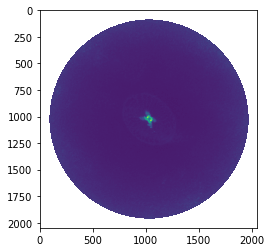

In [23]:
sigclip.max(axis=0).quicklook()

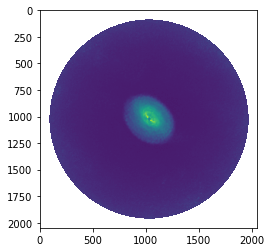

In [24]:
cube.max(axis=0).quicklook()